## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

This report focuses on developig AI models for the task of forecasting gold prices in USD based on 6 other currencies including USD. Eventhough the dataset includes data for the daily gold prices since 1985 till 2023, the model is trained only on data from 2010 since the patterns and amounts of gold price have changed since 2006. The model developed to predict this task is a deep learning model which uses LSTM nodes to learn patterns of the data. The model is fairly complex with a high number of nodes but with only few layers. The model is able to predict the daily gold prices in USD for 14 days to the future with minimal mean absolute error. The model has limitations due when it comes to sudden fluctuations but is still able to correctly identify patterns with some level of accuracy. The averag absolute error across the 14 days is 38.04. The model can be used by organisations in the Jewelery industry to succesfully predict the selling price of gold in USD based on EUR, GBP,
INR, AED, CNY and USD.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

**Data loading and column indexes**

Before proceeding with the model development, the dataset containing the gold prices was loaded to the colab local memory. After inspection, no missing values were noted.

Further, the date time column was selected as the index for the dataframe as the goal is time series prediction. Target column is also identified as first column (0 index) as it contains USD prices.

**Data inspection**

Upon visualising the 6 different currencies, it was observed that all currencies (gold price predictions) mostly follow the same trend.

Two different price ranges can be observed before and after 2006. Prior to 2006, the average USD gold prices have been $632.31 stable with less fluctuations and also was lower in general than after 2006.

The gold prices have sharply increased after 2006 with an average value of $ 1591.38 and also have been experiencing more fluctuations. However, based on the visualisation, the period after 2006,has more similar to the prices ranges and fluctuation patterns of the forecasting horizon.

**Splitting data**

Since the testing period has been specified, the challange was to identify the best training data period. Based on the differences in means and visualisations, different periods after 2006 was selected.

Different n step values have been tested and when using the 75 days to predict the two weeks gold prices yeilds the best results.

The selected datasets have been scalled using the min max scaller to overcome any limitations put forth by anomalies. Further, it is important to note that gold prices in INR is much higher if just observed by the value of currency. Scalling will resolve this issues along with differences in fluncuation amounts between currencies.

The y label has been selected as index 0 column of the dataset to predict gold price value in USD.

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from keras.layers import GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

set_seed(455)
np.random.seed(455)

In [ ]:
#view gold prices df
file_path = '/content/Part3_GoldPrice.csv'
gold_prices = pd.read_csv(file_path,index_col='Date', parse_dates=["Date"])
gold_prices.head()

,USD,EUR,GBP,INR,AED,CNY
Date,,,,,,
7/01/1985,298.25,392.55,261.17,3741.23,1091.58,835.80
8/01/1985,302.00,395.32,263.07,3820.70,1114.06,853.01
9/01/1985,300.50,393.54,263.14,3742.23,1097.47,840.31
10/01/1985,303.80,397.63,268.02,3853.39,1126.83,862.79
11/01/1985,304.25,398.60,270.57,3845.57,1135.85,869.69


In [ ]:
gold_prices.isna().sum()

,0
USD,0
EUR,0
GBP,0
INR,0
AED,0
CNY,0


In [ ]:
gold_prices.index = pd.to_datetime(gold_prices.index, format='%d/%m/%Y')

In [ ]:
gold_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10110 entries, 1985-01-07 to 2023-10-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD     10110 non-null  float64
 1   EUR     10110 non-null  float64
 2   GBP     10110 non-null  float64
 3   INR     10110 non-null  float64
 4   AED     10110 non-null  float64
 5   CNY     10110 non-null  float64
dtypes: float64(6)
memory usage: 552.9 KB


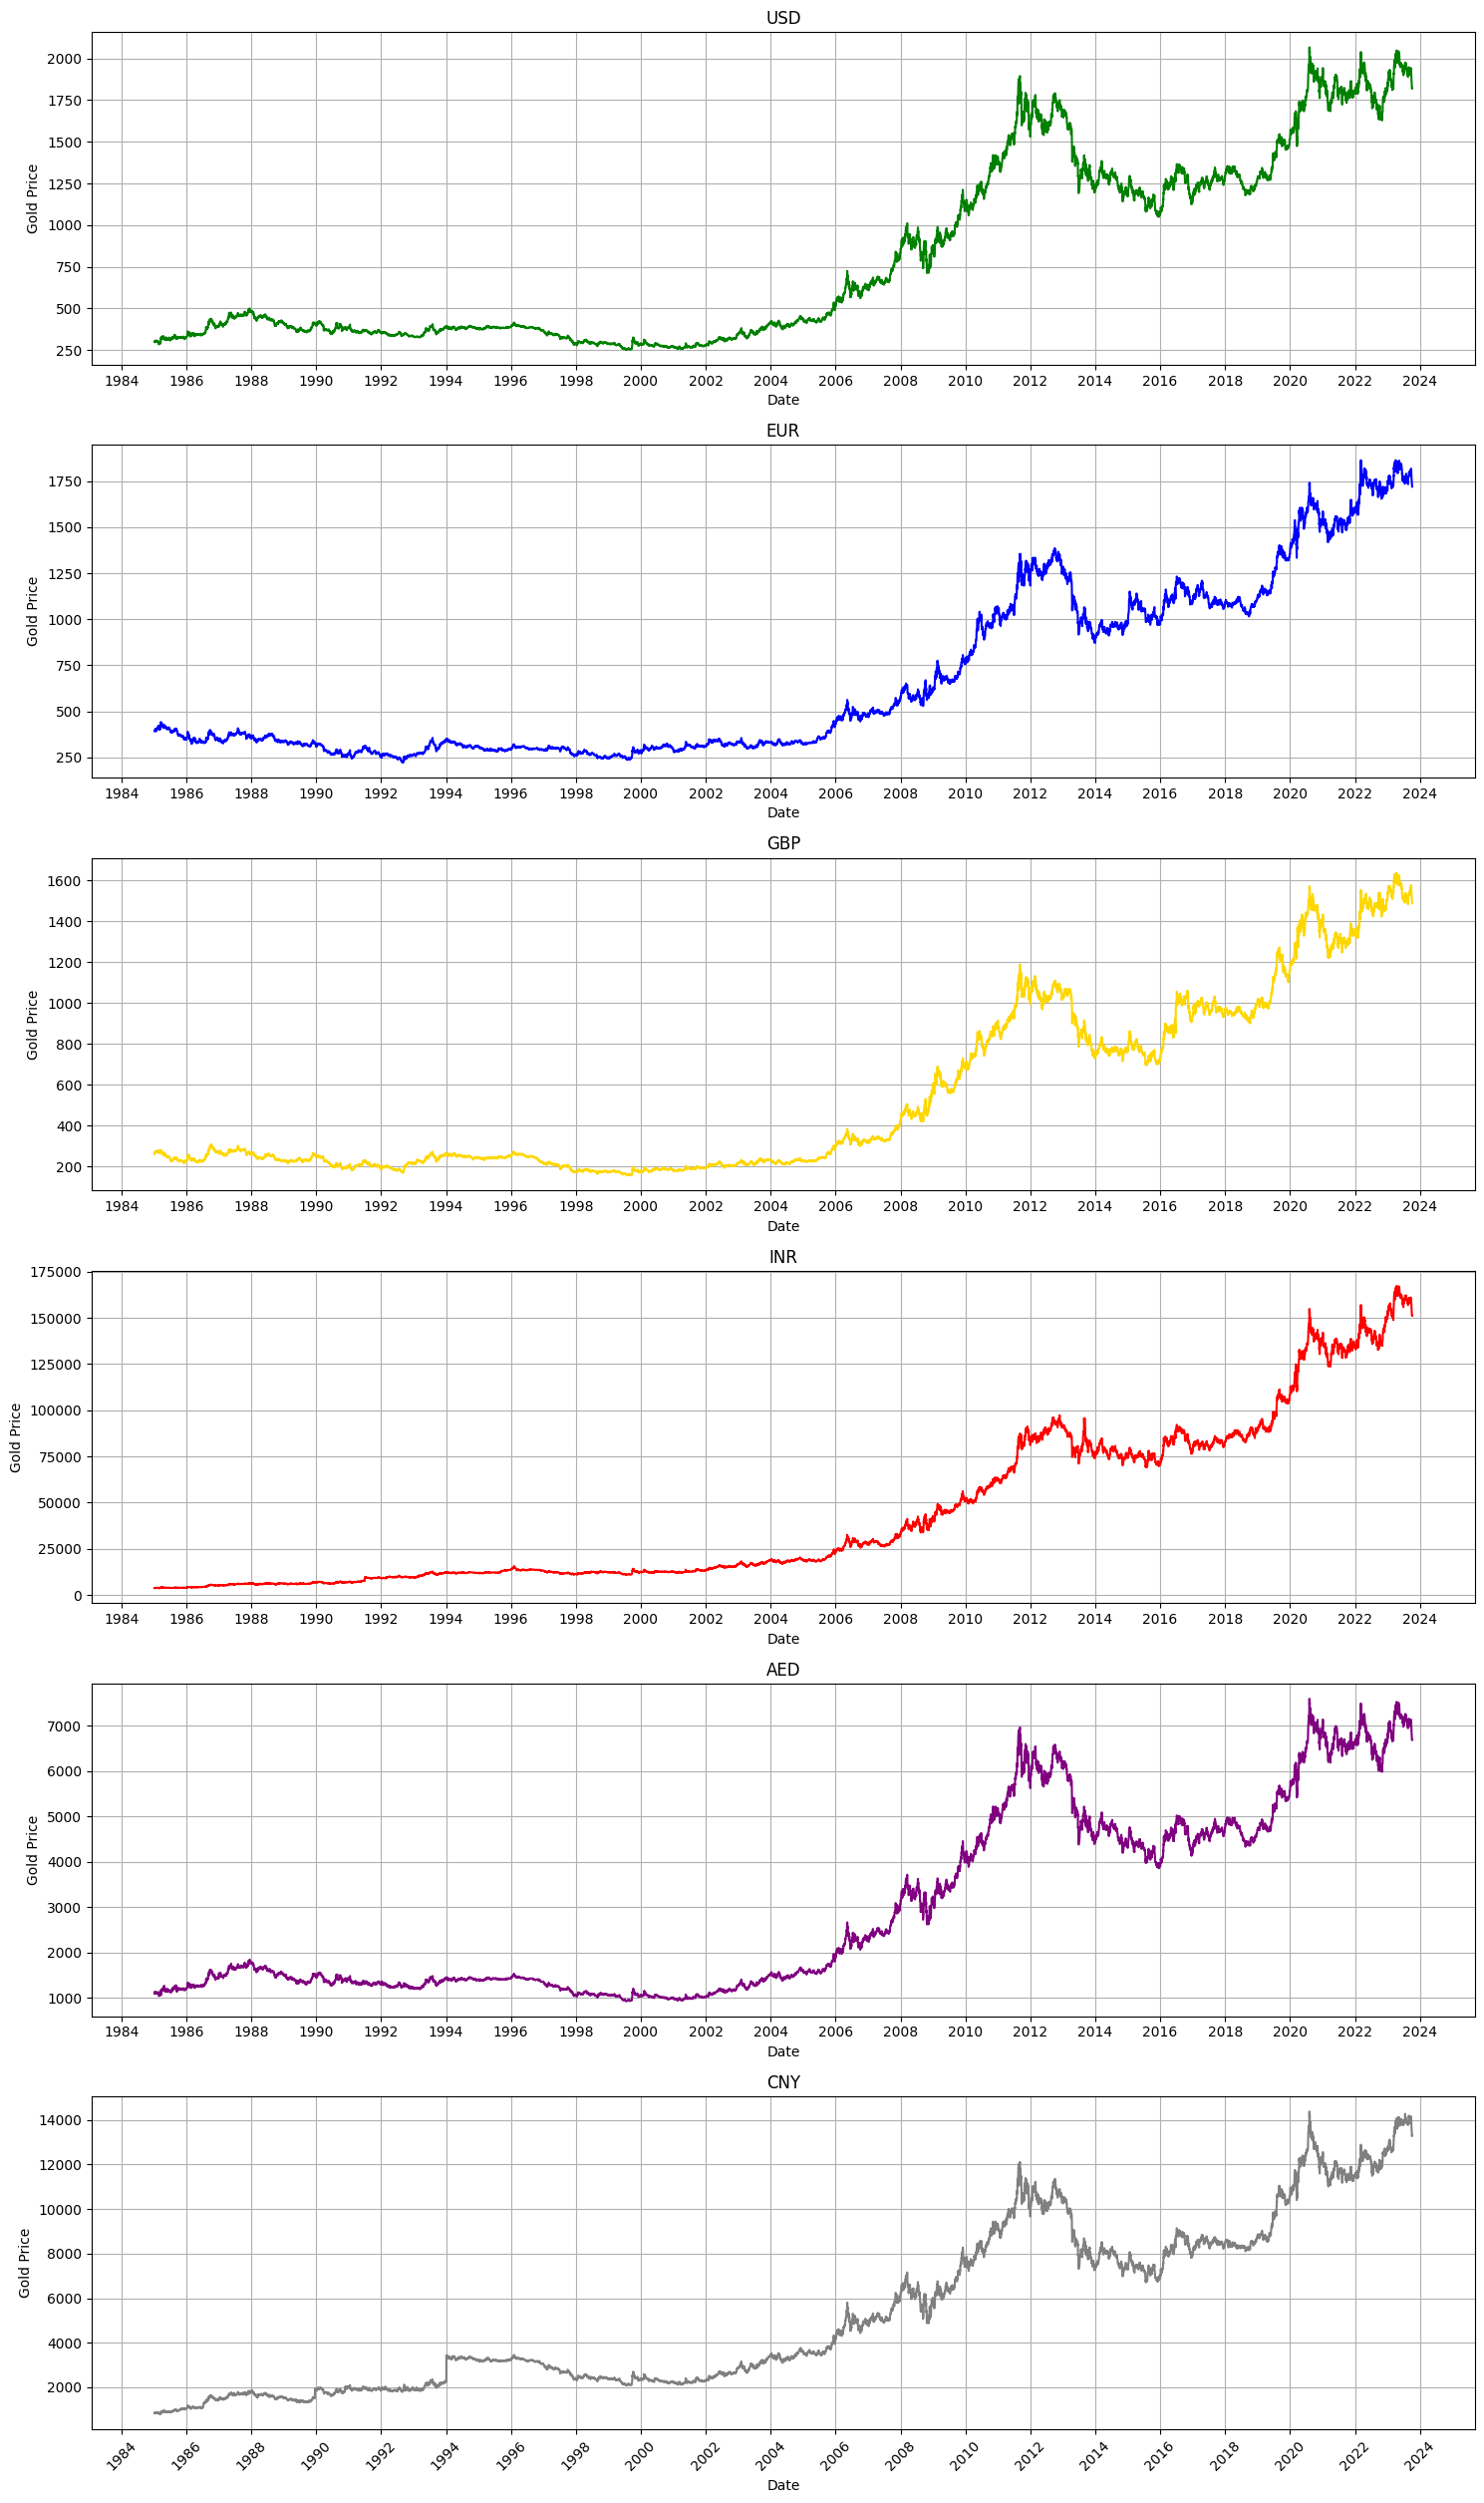

In [ ]:
# Visualizing gold prices for different currencies
fig, axs = plt.subplots(6, 1, figsize=(15, 25))

# Plotting each currency
axs[0].plot(gold_prices.index, gold_prices['USD'], color='green')
axs[0].set_title('USD')
axs[1].plot(gold_prices.index, gold_prices['EUR'], color='blue')
axs[1].set_title('EUR')
axs[2].plot(gold_prices.index, gold_prices['GBP'], color='gold')
axs[2].set_title('GBP')
axs[3].plot(gold_prices.index, gold_prices['INR'], color='red')
axs[3].set_title('INR')
axs[4].plot(gold_prices.index, gold_prices['AED'], color='purple')
axs[4].set_title('AED')
axs[5].plot(gold_prices.index, gold_prices['CNY'], color='grey')
axs[5].set_title('CNY')

# Add common x-axis label
for ax in axs:
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price')
    ax.grid(True)

# Formatting the x-axis to show every 2 years
for ax in axs:
    ax.xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks every 2 years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

# Adjust layout to prevent overlap
plt.tight_layout()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

In [ ]:
gold_prices.shape

(10110, 6)

In [ ]:
#average price before 2006 and after 2006 in USD

# Filter data for the periods
df_before_2016 = gold_prices[gold_prices.index.year <= 2016]
df_after_2016 = gold_prices[gold_prices.index.year > 2016]

# Calculate the mean value for USD in each period
mean_before_2016 = df_before_2016['USD'].mean()
mean_after_2016 = df_after_2016['USD'].mean()

print(f"Mean USD value up to and including 2016: {mean_before_2016}")
print(f"Mean USD value after 2016: {mean_after_2016}")

Mean USD value up to and including 2016: 632.3145416417017
Mean USD value after 2016: 1591.3835410764873


Splitting training set and testing set

In [ ]:
#average price after 2020 in USD

# Filter data for the periods
df_after_2020 = gold_prices[gold_prices.index.year >= 2020]


# Calculate the mean value for USD in each period
mean_after_2020 = df_after_2020['USD'].mean()

print(f"Mean USD value after 2020: {mean_after_2020}")

Mean USD value after 2020: 1818.2086978636828


In [ ]:
#Selecting the training period 2010 - 2021
tstart = 2010
tend = 2021

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}"]
    test = dataset.loc[f"{tend+1}":]
    return train, test
training_set, test_set = train_test_split(gold_prices, tstart, tend)

In [ ]:
training_set_shape = training_set.shape
test_set_shape = test_set.shape
print('training_set shape:', training_set_shape)
print('test_set shape:', test_set_shape)

training_set shape: (3131, 6)
test_set shape: (460, 6)


Scalling using min max scaller

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled shape after scaling:', training_set_scaled.shape)

training_set_scaled shape after scaling: (18786, 1)


In [ ]:
#Transform back to table format with 6 features
training_set_scaled = training_set_scaled.reshape(training_set_shape[0], training_set_shape[1])
print('training_set_scaled shape:', training_set_scaled.shape)

training_set_scaled shape: (3131, 6)


Defining a function to get split and number of n steps

In [ ]:
def split_sequence(sequence, n_steps,forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon,y_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#Looking at past 75 days to predict future 14 days
n_steps = 75
forecasting_horizon = 14
features = 6
y_index = 0 # the index of USD column
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon,y_index)

In [ ]:
# Reshaping X_train for model
y_train  = y_train.reshape(y_train .shape[0],y_train.shape[1],1)

In [ ]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (3043, 75, 6)
y_train shape: (3043, 14, 1)


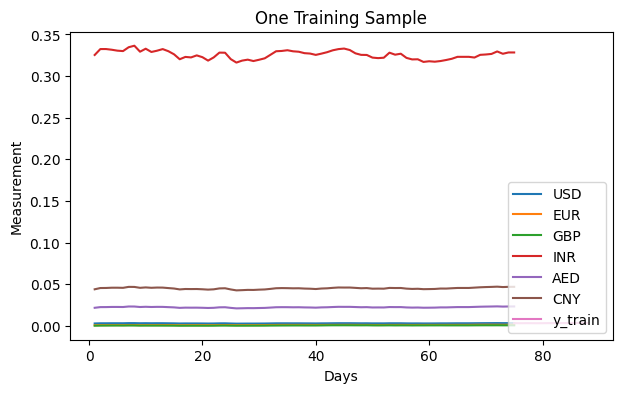

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,0])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,1])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,2])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,3])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,4])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,5])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Days')
plt.legend(['USD','EUR','GBP','INR','AED','CNY','y_train'], loc='lower right')

<a id = "cell_model"></a>
## 3. Predictive Modeling

**Overview**

In order to develop the final solution, 10 different models were tested with differences in architecture, parameters, activations and optimizers. Further, these models were tested on different datasets with different time periods as well as different n steps.

The model will use 6 different currencies USD, INR, CYN,EUR, GPB and AED to performe multi variate time series prediction and predict Gold prices in USD.


**Best model LSTM with 2 layers and Adam optimizer**

The best performing model has 2 hidden layers. The first layer includes 150 units with activation function as tanh. This layer has a drop out of 0.2 to prevent over fitting. This layer has return sequence set to true to input results to the second hidden layer.

The second hidden layer has 70 units and no drop out. The activation function is the same with using tanh.

The model has a total of 157,074 trainable parameters.

The model has 14 output units for the 14 days of predicting.

This model gains the best performance when it is run with optimiser set as Adam. The model has a low learning rate of 0.0001. The same model's performance drops when learning rate is closer to one (eg: 0.001, 0.05). Further, different beta values were tested but performance decreases if they are close to 0.

The model will monitor loss with mean absolute error (MAE), MAE was selected as it will out put the loss in the same unit as the prediction.

The model perfomes best at 65 epoches with batch size25. A larger batch size or more number of epochs will over fit the results.



In [ ]:
#LSTM model with two layers
#Best model
model_lstm = Sequential()

# First LSTM layer
model_lstm.add(LSTM(units=150, activation="tanh", return_sequences=True, input_shape=(n_steps, features)))
model_lstm.add(Dropout(0.2))

# Second LSTM layer
model_lstm.add(LSTM(units=70, activation="tanh",return_sequences=False, input_shape=(n_steps, features)))

# Output layer
model_lstm.add(Dense(units=14))

# Compiling the model, best performance with Adam optimizer
model_lstm.compile( optimizer=Adam(learning_rate=0.0001),loss="mae")

#Second best performance with RMSprop
#model_lstm.compile(optimizer=RMSprop(learning_rate=0.0001, rho=0.7), loss="mse")

# Print model summary
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 75, 150)             │          94,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 70)                  │          61,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │             994 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,074 (613.57 KB)

 Trainable params: 157,074 (613.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm.fit(X_train, y_train, epochs=65, batch_size=25)

Epoch 1/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0060
Epoch 2/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034
Epoch 3/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0027
Epoch 4/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022
Epoch 5/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019
Epoch 6/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016
Epoch 7/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0014
Epoch 8/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0012
Epoch 9/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 10/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.7034e-04
Epoch 11/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7007e-04
Epoch 12/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7086e-04
Epoch 13/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0796e-04
Epoch 14/65
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4965e-04
Epoch 15/65
122/122 ━━━━━━━━━━━

Model testing

In [ ]:
#scaling
inputs = test_set.values.reshape(-1, 1)
inputs = sc.transform(inputs)
#Reshape back to orignal format after rescaling
inputs = inputs.reshape(test_set_shape[0], test_set_shape[1])

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon,y_index)
number_test_samples = X_test.shape[0]
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (372, 75, 6)
y_test shape: (372, 14)


In [ ]:
#prediction
predicted_gold_price = model_lstm.predict(X_test)

#inverse transform the predicted values
predicted_gold_price = sc.inverse_transform(predicted_gold_price)
print('predicted_gold_price shape: ', predicted_gold_price.shape)

#inverse transform the test labels.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = sc.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted_gold_price shape:  (372, 14)


In [ ]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_gold_price[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 19.18.

Forecasting Horizon: 1 
Mean Absolute Error 24.72.

Forecasting Horizon: 2 
Mean Absolute Error 29.01.

Forecasting Horizon: 3 
Mean Absolute Error 30.44.

Forecasting Horizon: 4 
Mean Absolute Error 38.80.

Forecasting Horizon: 5 
Mean Absolute Error 33.65.

Forecasting Horizon: 6 
Mean Absolute Error 33.74.

Forecasting Horizon: 7 
Mean Absolute Error 38.27.

Forecasting Horizon: 8 
Mean Absolute Error 47.92.

Forecasting Horizon: 9 
Mean Absolute Error 41.43.

Forecasting Horizon: 10 
Mean Absolute Error 41.71.

Forecasting Horizon: 11 
Mean Absolute Error 44.89.

Forecasting Horizon: 12 
Mean Absolute Error 48.90.

Forecasting Horizon: 13 
Mean Absolute Error 47.77.



In [ ]:
X_test = X_test.reshape(-1,75)
X_test = sc.inverse_transform(X_test)
X_test = X_test.reshape(number_test_samples, 75,6)

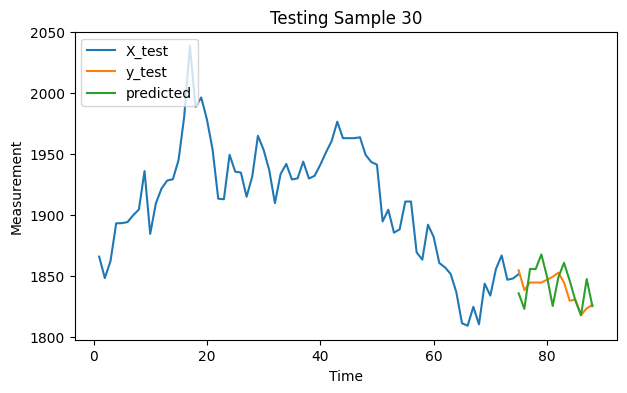

In [ ]:
#real vs. predicted values of a testing segment by looking at 75 days and predicting for 14 days
sample_index = 30

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:,0])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_gold_price[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Gold Price Prediction for one day based on all samples")
    plt.xlabel("Sample index")
    plt.ylabel("Gold Stock Price")
    plt.legend()
    plt.show()

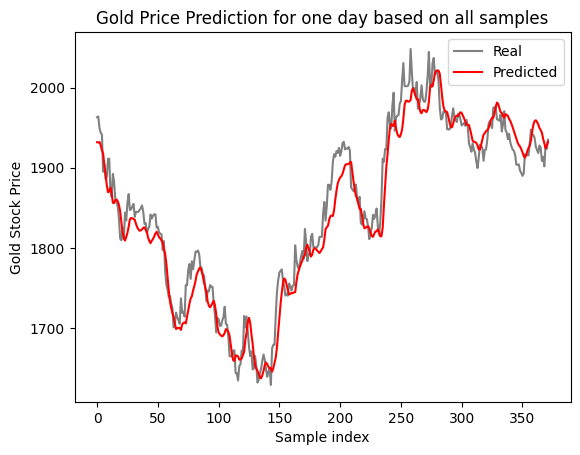

In [ ]:
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[:,0],predicted_gold_price[:,0])

<a id = "cell_report"></a>
## 4. Experiments Report

**Performance of model 3**

The best model for the task of predicting gold prices in USD is model 3 with Adam optimiser.

The model performance is satisfactory as it is able to predict all 14 days roughly within 50 MAE.

The average MAE across 14 days is 38.04.

Further, it is important to note that model has similar mean absolute error rates across all 14 predictions.

Further, when considering all the samples for one day, this model is able to identify the pattern well. However, there are limitations when it comes to sudden fluctuations. the model is still able to detect the pattern but the MAE is a bit high for these values.

Further, The model is still still over fitting the training data to a certain degree. this is evident when looking at performance of one sample and is a limitation.

There were limitations in training the models due to usage limits of GPU in colab. However, this model can be further improved with use and further training.

**Performance of other models**

The models with more layers such as model 7 and 8 did not perform well as they tend to overfit the data given the model complexity. Further, the worst performing model is RNN 5 with a high learning rate set to 0.5.

Models with many layers but with low nodes also did not perform well. Therefore, inorder to balance between complexity and not over fitting the model 3 was developed with two layers but 150 nodes and 0.2 drop out. second layer also consists of 70 nodes.

**N step**

When the model is looking at a higher number of days to forecast two weeks the accuracy drops. This is demonstrated with 100 nstep.

In contrast when the model looks at 50 days to predict 14 days, the error is reduced. However, the ideal n step for model 3 would be 75 days.

**Time period (Lag)**

The time period from 2016 onwards will also produce a higher error when compared with time set as 2008. The reason that a longer lag and a shorter n step is best for model 3 could be because of the nature of the dataset. The dataset has an increasing trend with many peaks and drops (fluctuations), therefore when nstep is short and lag is high the model is able to learn the pattern well.


**Real world usage**

The model is able to predict the gold price in USD, based on 6 different currencies. The mean dollar price for 2022 till 2023 is USD 1818.20 and this model is able to predict it with onlhy around $50.00 error.

The model can be used to predict the dollar value of gold when the price of gold is known in the 5 currencies of Euro, GBP, CYN, AED and INR. In the real world, the model can be used to give accurate predictions for two weeks ahead. Therefore, can be utilised by jewellary selling companies or exporters.

In [ ]:
#Model performance as a dataframe
models_path = '/content/part c models .xlsx'
models = pd.read_excel(models_path)
models.head(10)

,Model,Model architechture,Optimizer,Mae Forecast Day 1,Mae Forecast Day 2,Mae Forecast Day 3,Mae Forecast Day 4,Mae Forecast Day 5,Mae Forecast Day 6,Mae Forecast Day 7,Mae Forecast Day 8,Mae Forecast Day 9,Mae Forecast Day 10,Mae Forecast Day 11,Mae Forecast Day 12,Mae Forecast Day 13,Mae Forecast Day 14
0,RNN 1 (LSTM),"1 layer with 120 units ,",RMS Prop,194.27,166.98,204.55,178.54,149.42,172.76,173.73,168.24,153.18,226.47,187.90,175.16,208.22,156.30
1,RNN 2 (LSTM),"Layer 1 with 120 units, Layer 2 with 50 units","RMS Prop (Learning rate 0.001, rho = 0.7, mome...",129.68,212.03,150.32,208.46,170.54,152.51,186.19,130.13,107.54,200.11,107.94,200.11,107.93,109.95
2,Best model RNN 3 (LSTM),"Layer 1 with 150 units and drop out 0.2, Layer...","Optimizer = RMS Prop (Learning rate 0.0001, rh...",91.50,76.95,71.97,118.68,34.03,70.00,52.80,91.04,117.60,120.91,180.94,140.18,196.50,112.13
3,Best model RNN 3 (LSTM),"Layer 1 with 150 units and drop out 0.2, Layer...","Optimizer = Adam (Learning rate 0.0001, rho = ...",22.43,56.65,25.69,28.44,28.64,31.60,32.60,37.53,37.82,45.51,43.29,48.73,46.10,47.57
4,RNN 4 (LSTM),"Layer 1 with 150 units and drop out 0.2, Layer...","Adam (Learning rate = 0.0001, beta = 0.9, beta...",86.91,76.24,142.71,75.81,143.09,198.15,198.82,201.13,99.67,169.39,164.16,81.27,113.97,204.29
5,RNN 5 (LSTM),"Layer 1 with 150 units and drop out 0.2, Layer...","RMS Prop (Learning rate 0.5, rho = 0.7, moment...",5299.86,3752.97,3854.72,1865.38,2579.00,3062.50,3158.03,6793.70,4754.82,6722.15,2822.50,1606.99,1671.07,8332.89
6,RNN 6 (GRU),"Layer 1 with 150 units and drop out 0.2, Layer...","RMS Prop (Learning rate 0.001, rho = 0.9, mome...",144.99,233.17,209.39,207.46,155.46,158.95,121.55,66.09,117.02,126.30,125.36,113.68,162.86,137.52
7,RNN 7 (LSTM),"Layer 1 with 150 nodes and 0.2 drop out, Layer...","RMS Prop (Learning rate 0.001, rho = 0.9, mome...",240.88,216.88,238.48,240.18,264.23,199.12,177.21,224.36,192.96,105.19,273.38,114.64,93.26,107.07
8,RNN 8 (LSTM),"Layer 1 with 100 nodes and 0.2 drop out, Layer...",RMS Prop (Learning rate 0.001),195.93,180.91,152.50,124.93,159.56,141.07,133.10,155.32,97.75,142.97,144.02,104.41,126.14,93.24
9,RNN 9 (LSTM) with L2 regularization,"First layer with 50 nodes and 0.3 drop out, se...",RMS Prop (Learning rate 0.001),453.81,511.81,493.59,148.56,500.70,525.28,453.19,529.05,230.57,490.48,217.50,465.23,247.96,436.34


In [ ]:
#Best Model performance with n step as 50 vs 100
models_path_2 = '/content/part c horizon.xlsx'
models_2 = pd.read_excel(models_path_2)
models_2

,Model,Model architechture,Optimizer,Mae Forecast Day 1,Mae Forecast Day 2,Mae Forecast Day 3,Mae Forecast Day 4,Mae Forecast Day 5,Mae Forecast Day 6,Mae Forecast Day 7,Mae Forecast Day 8,Mae Forecast Day 9,Mae Forecast Day 10,Mae Forecast Day 11,Mae Forecast Day 12,Mae Forecast Day 13,Mae Forecast Day 14
0,n step 100,"Layer 1 with 150 units and drop out 0.2, Layer...","RMS Prop (Learning rate 0.001, rho = 0.7, mome...",97.03,94.15,92.26,90.67,80.14,98.77,111.88,83.64,135.11,133.17,137.82,100.26,"102,97",102.99
1,n step 50,"Layer 1 with 150 units and drop out 0.2, Layer...","RMS Prop (Learning rate 0.001, rho = 0.7, mome...",22.96,36.59,29.71,61.14,47.30,51.64,53.14,45.19,40.48,49.55,45.86,54.55,47,53.67


In [ ]:
#Best Model performance with tranining period as 2015 till 2021 and 2008 till 2021
models_path_3 = '/content/part c time.xlsx'
models_3 = pd.read_excel(models_path_3)
models_3

,Model,Model architechture,Optimizer,Mae Forecast Day 1,Mae Forecast Day 2,Mae Forecast Day 3,Mae Forecast Day 4,Mae Forecast Day 5,Mae Forecast Day 6,Mae Forecast Day 7,Mae Forecast Day 8,Mae Forecast Day 9,Mae Forecast Day 10,Mae Forecast Day 11,Mae Forecast Day 12,Mae Forecast Day 13,Mae Forecast Day 14
0,2015 -2021,"Layer 1 with 150 units and drop out 0.2, Layer...","RMS Prop (Learning rate 0.001, rho = 0.7, mome...",59.27,67.18,92.13,135.91,135.42,60.42,90.56,47.76,109.38,99.4,115.87,178.98,102.01,98.33
1,2008-2021,"Layer 1 with 150 units and drop out 0.2, Layer...","RMS Prop (Learning rate 0.001, rho = 0.7, mome...",21.58,21.93,23.86,42.24,30.68,32.17,57.63,38.65,43.08,39.5,42.80,56.95,52.98,48.41
